# Mouse Allen to fluoro example

This example maps betwen the allen CCF mouse atlas and fluorescence mouse image.

Here we will use affine alignment in adition to deformable registration.  

Affine will be performed first, then both will be performed simultaneously.

Also we will estimate artifact locations using the EM algorithm and compensate for them in our matching.

## Library imports
We start by importing necessary libraries.  That includes numpy, matplotlib, and tensorflow for numerical work, nibabel for loading neuroimages, and lddmm and vis which are part of this library.

In [2]:
import numpy as np # for arrays
%matplotlib notebook
import matplotlib as mpl # for graphics
import matplotlib.pyplot as plt
import nibabel as nib # for loading neuroimages
import lddmm # algorithm
import vis # visualization
import tensorflow as tf
import imp # use imp.reload to update modules during development

In [3]:
# get filenames
atlas_image_fname = 'average_template_50.img'
target_image_fname = '180517_Downsample.img'

In [4]:
# load them with nibabel
fnames = [atlas_image_fname,target_image_fname]
img = [nib.load(fname) for fname in fnames]

In [5]:
# get info about image space
if '.img' == atlas_image_fname[-4:]:    
    nxI = img[0].header['dim'][1:4]
    dxI = img[0].header['pixdim'][1:4]
    nxJ = img[1].header['dim'][1:4]
    dxJ = img[1].header['pixdim'][1:4]
else:
    # I'm only working with analyze for now
    raise ValueError('Only Analyze images supported for now')
xI = [np.arange(nxi)*dxi - np.mean(np.arange(nxi)*dxi) for nxi,dxi in zip(nxI,dxI)]
xJ = [np.arange(nxi)*dxi - np.mean(np.arange(nxi)*dxi) for nxi,dxi in zip(nxJ,dxJ)]

In [6]:
# get the images, note they also include a fourth axis for time that I don't want
I = img[0].get_data()[:,:,:,0]
J = img[1].get_data()[:,:,:,0]

In [7]:
I.shape,J.shape

((160, 264, 228), (228, 160, 270))

In [6]:
# pad so that there is a black boundary, this improves extrapolation when deforming the Allen atlas
I = np.pad(I,1,mode='constant',constant_values=0)
nxI += 2
xI = [np.arange(nxi)*dxi - np.mean(np.arange(nxi)*dxi) for nxi,dxi in zip(nxI,dxI)]

<IPython.core.display.Javascript object>


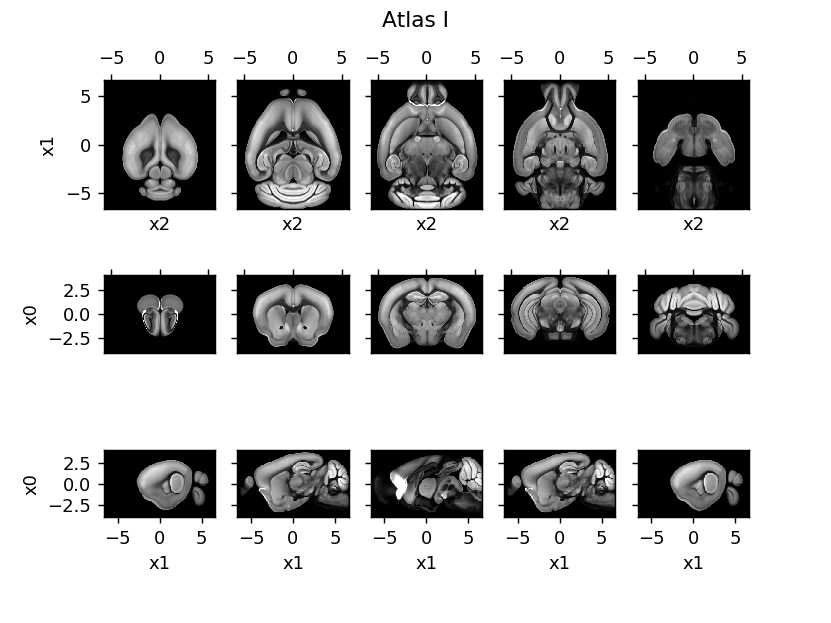

In [7]:
# display the data
f = plt.figure()
vis.imshow_slices(I, x=xI, fig=f)
f.suptitle('Atlas I')
f.canvas.draw()

<IPython.core.display.Javascript object>


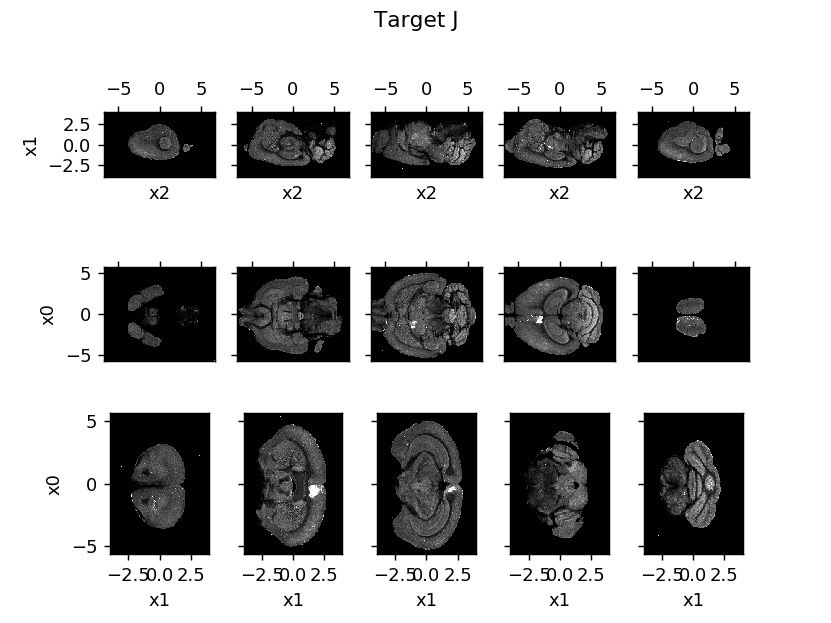

In [8]:
f = plt.figure()
vis.imshow_slices(J,x=xJ,fig=f)
f.suptitle('Target J')
f.canvas.draw()

Notice that this image has a giant bright spot.  This is an artifact we will need to compensate for in order to do accurate registration.

## Reorientation
The allen atlas is not stored in the same orientation as our data, we will specify an initial affine transformation to put it in the correct transformation.

In [9]:
# the line below is a good initial orientation
A = np.array([[ 0,0,1,0],
              [-1,0,0,0],
              [ 0,1,0,0],
              [ 0,0,0,1]])

<IPython.core.display.Javascript object>


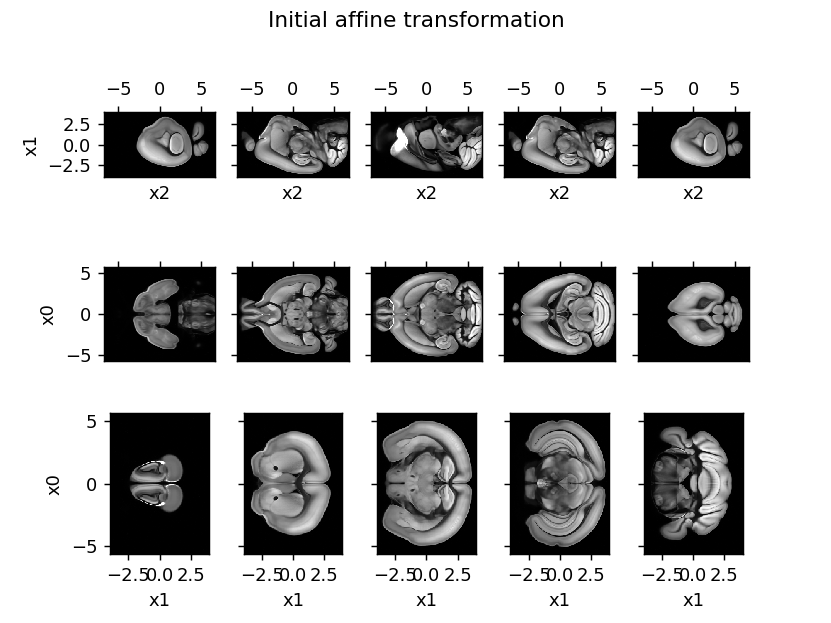

In [10]:
# test the initial affine
X0,X1,X2 = np.meshgrid(xJ[0],xJ[1],xJ[2],indexing='ij')
X0tf = tf.constant(X0,dtype=lddmm.dtype)
X1tf = tf.constant(X1,dtype=lddmm.dtype)
X2tf = tf.constant(X2,dtype=lddmm.dtype)
Itf = tf.constant(I,dtype=lddmm.dtype)
B = np.linalg.inv(A)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    Xs = B[0,0]*X0tf + B[0,1]*X1tf + B[0,2]*X2tf + B[0,3]
    Ys = B[1,0]*X0tf + B[1,1]*X1tf + B[1,2]*X2tf + B[1,3]
    Zs = B[2,0]*X0tf + B[2,1]*X1tf + B[2,2]*X2tf + B[2,3]
    Id = lddmm.interp3(xI[0], xI[1], xI[2], Itf, Xs, Ys, Zs)
    Idnp = Id.eval()
f = plt.figure()
vis.imshow_slices(Idnp,x=xJ,fig=f)
f.suptitle('Initial affine transformation')
f.canvas.draw()


## Run DR IT MD matching

Because of the artifact we will run the missing data version of the algorithm.  This can be specified by setting the `nMstep` argument to an integer grater than 0.  This parameters says how many iterations of gradient descent are used in the maximization step of the EM algorithm.

Set default parameters
Initial affine transform [[ 0  0  1  0]
 [-1  0  0  0]
 [ 0  1  0  0]
 [ 0  0  0  1]]
Got parameters


<IPython.core.display.Javascript object>


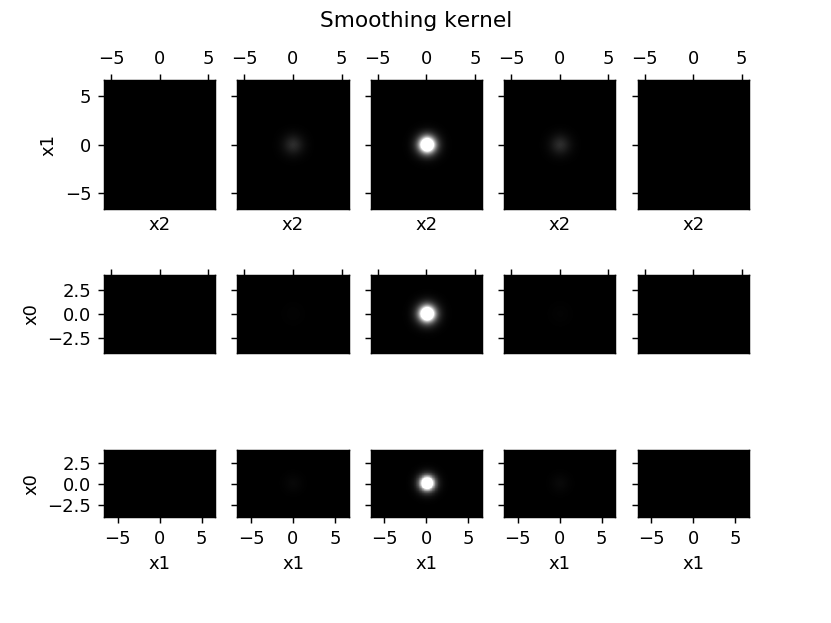

Built energy operators
Built tensorflow variables
Computation graph defined


<IPython.core.display.Javascript object>


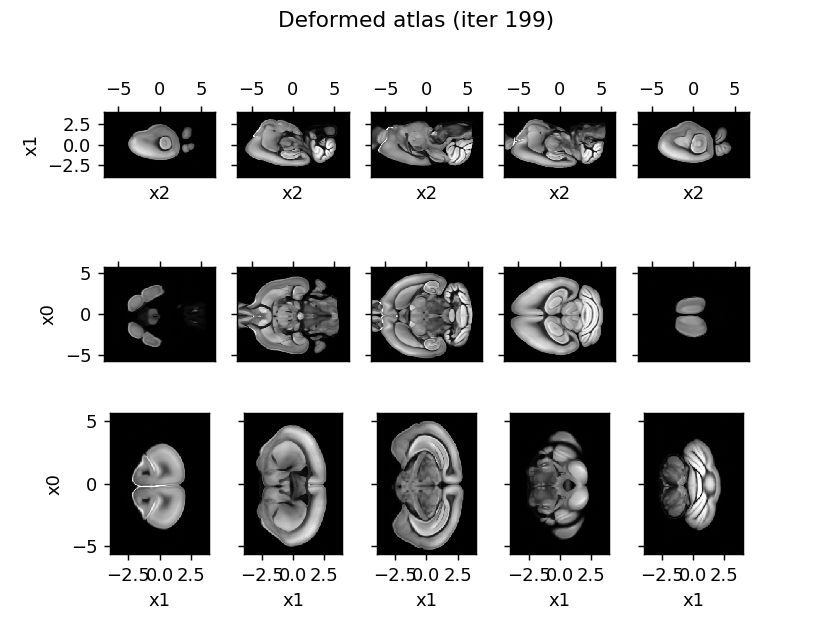

<IPython.core.display.Javascript object>


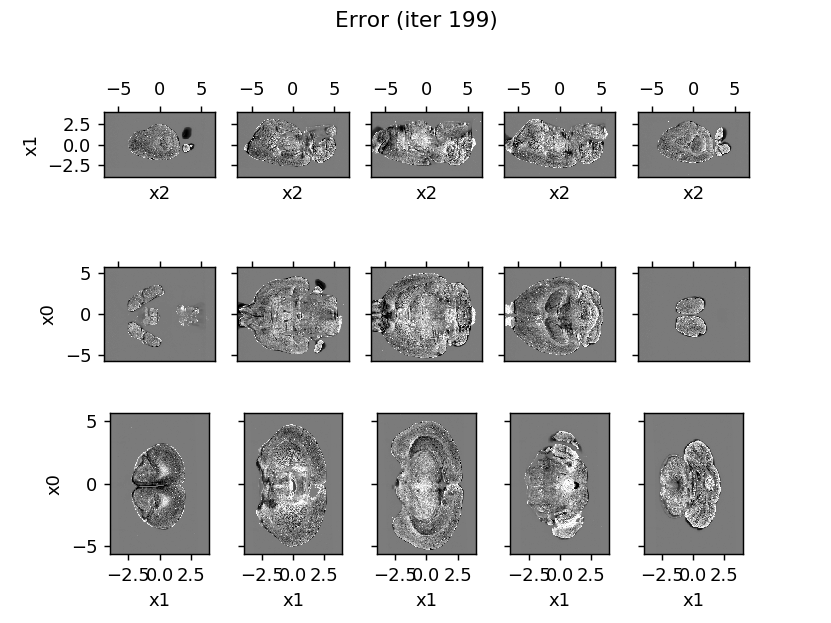

<IPython.core.display.Javascript object>


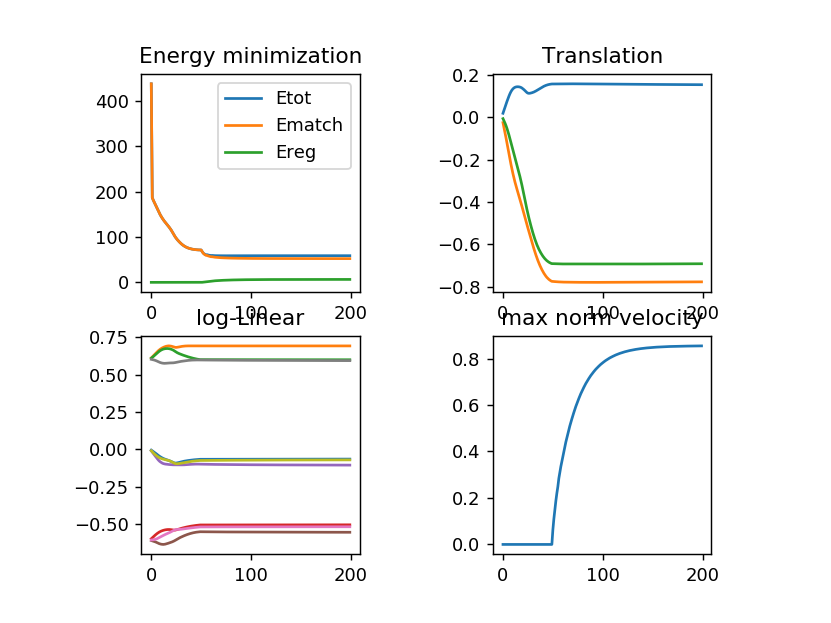

<IPython.core.display.Javascript object>


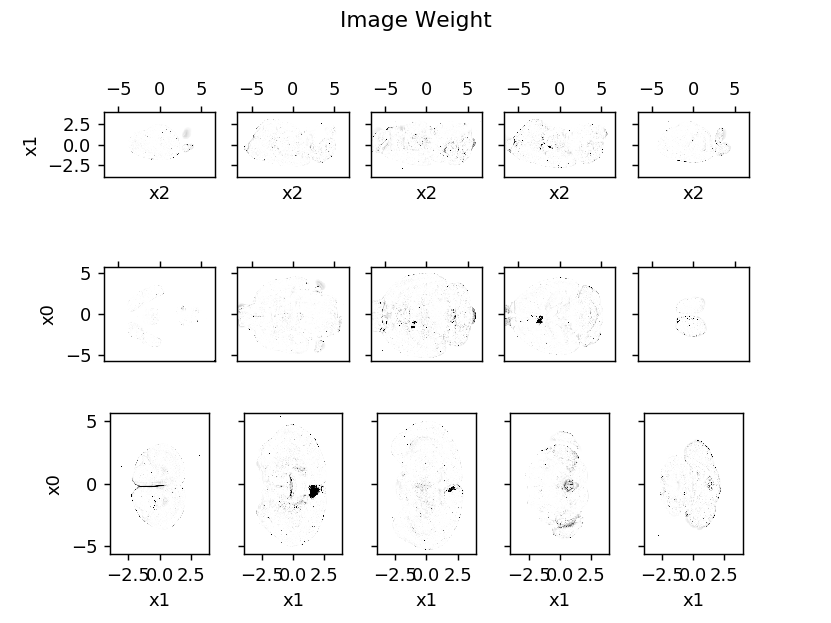

<IPython.core.display.Javascript object>


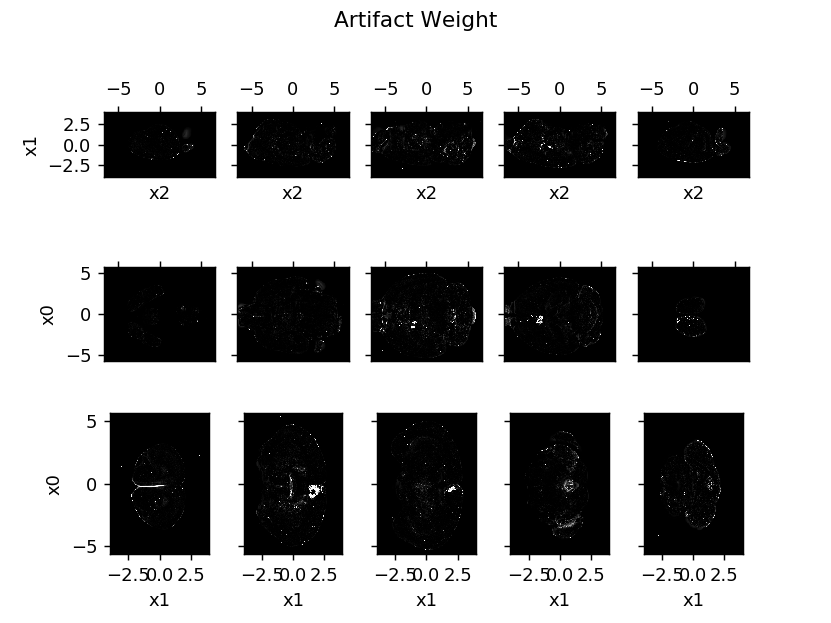

Taking affine only step
Updating weights
logm result may be inaccurate, approximate err = 1.863291762711072e-06


/cis/home/dtward/testenv/lib/python3.6/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Finished iteration 0, energy 4.371883e+02 (match 4.371883e+02, reg 0.000000e+00)
Taking affine only step
Updating weights
logm result may be inaccurate, approximate err = 9.187644807415489e-07
Finished iteration 1, energy 1.865109e+02 (match 1.865109e+02, reg 0.000000e+00)
Taking affine only step
Updating weights
logm result may be inaccurate, approximate err = 2.435616332942126e-06
Finished iteration 2, energy 1.809810e+02 (match 1.809810e+02, reg 0.000000e+00)
Taking affine only step
Updating weights
logm result may be inaccurate, approximate err = 2.0391893753986065e-06
Finished iteration 3, energy 1.763005e+02 (match 1.763005e+02, reg 0.000000e+00)
Taking affine only step
Updating weights
logm result may be inaccurate, approximate err = 1.1419973573381185e-06
Finished iteration 4, energy 1.719121e+02 (match 1.719121e+02, reg 0.000000e+00)
Taking affine only step
Updating weights
logm result may be inaccurate, approximate err = 7.934474661343886e-07
Finished iteration 5, energy 1.67

Updating weights
logm result may be inaccurate, approximate err = 5.882806217800501e-07
Finished iteration 43, energy 7.234723e+01 (match 7.234723e+01, reg 0.000000e+00)
Taking affine only step
Updating weights
logm result may be inaccurate, approximate err = 6.704903863002153e-07
Finished iteration 44, energy 7.206378e+01 (match 7.206378e+01, reg 0.000000e+00)
Taking affine only step
Updating weights
logm result may be inaccurate, approximate err = 6.226369956966968e-07
Finished iteration 45, energy 7.183303e+01 (match 7.183303e+01, reg 0.000000e+00)
Taking affine only step
Updating weights
logm result may be inaccurate, approximate err = 8.345055257105256e-07
Finished iteration 46, energy 7.166011e+01 (match 7.166011e+01, reg 0.000000e+00)
Taking affine only step
Updating weights
logm result may be inaccurate, approximate err = 8.710163081923143e-07
Finished iteration 47, energy 7.149712e+01 (match 7.149712e+01, reg 0.000000e+00)
Taking affine only step
Updating weights
logm result m

logm result may be inaccurate, approximate err = 8.910542716686665e-07
Finished iteration 87, energy 5.859765e+01 (match 5.304301e+01, reg 5.554641e+00)
Taking affine and deformation step
logm result may be inaccurate, approximate err = 6.188814236316732e-07
Finished iteration 88, energy 5.859701e+01 (match 5.299849e+01, reg 5.598521e+00)
Taking affine and deformation step
logm result may be inaccurate, approximate err = 1.05030392593767e-06
Finished iteration 89, energy 5.859593e+01 (match 5.295813e+01, reg 5.637797e+00)
Taking affine and deformation step
Updating weights
logm result may be inaccurate, approximate err = 7.486913816649853e-07
Finished iteration 90, energy 5.859615e+01 (match 5.292166e+01, reg 5.674490e+00)
Taking affine and deformation step
logm result may be inaccurate, approximate err = 3.5311247661331284e-07
Finished iteration 91, energy 5.861740e+01 (match 5.290918e+01, reg 5.708220e+00)
Taking affine and deformation step
logm result may be inaccurate, approximate 

Updating weights
logm result may be inaccurate, approximate err = 6.330225447599029e-07
Finished iteration 130, energy 5.869263e+01 (match 5.238932e+01, reg 6.303314e+00)
Taking affine and deformation step
logm result may be inaccurate, approximate err = 7.893272067943059e-07
Finished iteration 131, energy 5.869377e+01 (match 5.238642e+01, reg 6.307344e+00)
Taking affine and deformation step
logm result may be inaccurate, approximate err = 3.664395004863479e-07
Finished iteration 132, energy 5.869293e+01 (match 5.237891e+01, reg 6.314013e+00)
Taking affine and deformation step
logm result may be inaccurate, approximate err = 4.07790240617045e-07
Finished iteration 133, energy 5.869359e+01 (match 5.237449e+01, reg 6.319102e+00)
Taking affine and deformation step
logm result may be inaccurate, approximate err = 5.26760158369211e-07
Finished iteration 134, energy 5.869365e+01 (match 5.237073e+01, reg 6.322912e+00)
Taking affine and deformation step
Updating weights
logm result may be inac

logm result may be inaccurate, approximate err = 4.432326373076682e-07
Finished iteration 173, energy 5.870171e+01 (match 5.228505e+01, reg 6.416658e+00)
Taking affine and deformation step
logm result may be inaccurate, approximate err = 2.7872487328462524e-07
Finished iteration 174, energy 5.870134e+01 (match 5.228399e+01, reg 6.417352e+00)
Taking affine and deformation step
Updating weights
logm result may be inaccurate, approximate err = 6.675986468290788e-07
Finished iteration 175, energy 5.870144e+01 (match 5.228333e+01, reg 6.418108e+00)
Taking affine and deformation step
logm result may be inaccurate, approximate err = 9.574883744509581e-07
Finished iteration 176, energy 5.870429e+01 (match 5.228573e+01, reg 6.418555e+00)
Taking affine and deformation step
logm result may be inaccurate, approximate err = 3.2525443094543457e-07
Finished iteration 177, energy 5.870275e+01 (match 5.228100e+01, reg 6.421746e+00)
Taking affine and deformation step
logm result may be inaccurate, appro

In [11]:
# parameters
# cost function weights 1 / sigma^2
sigmaM = np.std(J) # matching
sigmaA = sigmaM*10.0 # artifact
sigmaR = 1e0 # regularization

# enery operator, power of laplacian p, characteristic length a
p = 2
a = (xI[0][1]-xI[0][0])*5

# other optimization parameters
niter = 200 # how many iteraitons of gradient descent
naffine = 50 # first naffine iterations are affine only (no deformation)
nt = 5 # this many timesteps to numerically integrate flow
# the linear part is a bit too big still (since I fixed voxel size issue)
# initial guess for affine (check picture above)
A0 = A

# When working with weights in EM algorithm, how many M steps per E step
# first test with 0 (it is working)
nMstep = 5
nMstep_affine = 1

# gradient descent step size
eL = 2e-4
eT = 1e-3
eV = 5e-3
# I think maybe eV has to be bigger
eV = 1e-2
# there is some oscilation in the translation and the linear part
eV = 5e-2

out = lddmm.lddmm(I, J, 
                  xI=xI, # location of pixels in domain
                  xJ=xJ,                  
                  niter=niter, # iterations of gradient descent
                  naffine=naffine, # iterations of affine only
                  eV = eV, # step size for deformation parameters
                  eT = eT, # step size for translation parameters
                  eL = eL, # step size for linear parameters
                  nt=nt, # timesteps for integtating flow
                  sigmaM=sigmaM, # matching cost weight 1/2sigmaM^2
                  sigmaR=sigmaR, # reg cost weight 1/2sigmaM^2
                  sigmaA=sigmaA, # artifact cost weight 1/2sigmaA^2
                  a=a, # kernel width
                  p=p, # power of laplacian in kernel (should be at least 2 for 3D)
                  A0=A0, # initial guess for affine matrix (should get orientation right)
                  nMstep=nMstep, # number of m steps for each e step
                  nMstep_affine=nMstep_affine # number of m steps during affine only phase
                 )

In [12]:
# TO DO include deforming labels